<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Data-Split" data-toc-modified-id="Data-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Split</a></span></li></ul></div>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv

from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('tweets.csv', encoding='utf-8', error_bad_lines=False, sep=',')
df.drop(['keyword', 'location', 'id'], axis=1, inplace=True)
display(df.sample(5))

,text,target
6225,Eden Hazard distracting the Iranian army https...,0
7380,Lets never forget the 14 January 2019 extra-le...,1
3329,sure am digging this deluge of hyper-criticism...,0
8998,Philip Schofield is really letting himself dow...,0
9658,ISIS strap suicide vests to PUPPIES in horror ...,0


In [5]:
df.shape

(11370, 2)

In [6]:
df['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

## Data Cleaning

In [7]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [8]:
display(df.sample(2))

,text,target,clean_text
8812,RSCL apathy delays Brahmani project - The New ...,0,rscl apathy delay brahmani project new indian ...
64,Iran Says That They Shot Down Ukraine Internat...,1,iran say shot ukraine international flight 172...


In [ ]:
# df.to_csv('tweets_processed.csv')

## Data Preparation

In [39]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

# Selecting only 20 samples for siamese model
disaster = disaster_initial[:20]
non_disaster = non_disaster_initial[:20]

# Creating pairs of data for siamese training => labels are just dummy variables 
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label'])

for data in disaster:
  a = data
  p = random.choice(disaster)
  n = random.choice(non_disaster)

  df2.loc[len(df2)] = [a, p, n, 1]


for data in non_disaster:
  a = data
  p = random.choice(non_disaster)
  n = random.choice(disaster)
  
  df2.loc[len(df2)] = [a, p, n, 1]

In [40]:
df2.shape

(40, 4)

In [41]:
display(df2.sample(5))

,Anchor,Positive,Negative,label
35,heartfelt appreciation prime minister yab tun ...,cool day git push origin currentbranchname kno...,cow today local factory sadly still ablaze red...,1
1,telangana section 144 impose bhainsa january 1...,telangana section 144 impose bhainsa january 1...,creature ’ soul longer clarent blue ablaze thi...,1
2,arsonist set car ablaze dealership,image show havoc cause cameroon military torch...,cool day git push origin currentbranchname kno...,1
17,marivan kurdistan province monday jan 13th 202...,hausa youth set area office apapaiganmu local ...,yeah new swag point 100 since accident like to...,1
11,french cameroun set house ablaze ndu roast two...,fire ablaze throughout landas prophosized apoc...,child chinese tweet would go viral social medi...,1


## Data Split

In [42]:
X_train, X_val, y_train, y_val = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2['label'], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(32, 3) (8, 3) (32,) (8,)


In [44]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

## Glove Embeddings

In [47]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')

In [49]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open('drive/My Drive/Glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [50]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [51]:
print(embedding_matrix.shape)

(313, 300)


## Siamese Model

In [52]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [54]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network


def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = Adam(0.001))
  return model

In [60]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            1826126     input_4[0][0]                    
                                                                 input_5[0][0]              

In [61]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [62]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val.reshape(-1,1)))

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.4594 - val_loss: 0.4244
Epoch 2/5
1/1 [==============================] - 1s 556ms/step - loss: 0.4121 - val_loss: 0.3234
Epoch 3/5
1/1 [==============================] - 1s 571ms/step - loss: 0.3123 - val_loss: 0.2943
Epoch 4/5
1/1 [==============================] - 1s 545ms/step - loss: 0.2492 - val_loss: 0.2895
Epoch 5/5
1/1 [==============================] - 1s 575ms/step - loss: 0.1972 - val_loss: 0.2831


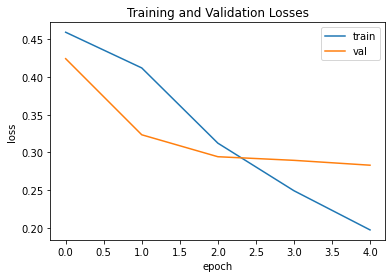

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [66]:
# Save model for further use
# serialize model to JSON
model_json = model.to_json()
with open("siamesemodel-triplet-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-triplet-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-triplet-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-triplet-loss.h5")
# print("Loaded model from disk")

Saved model to disk
